In [23]:
import numpy as np
from matplotlib import pyplot as plt
import pyemma
import sys
from tqdm.notebook import tqdm
import itertools

In [4]:
sys.path.append('/home/mi/thempel/code/information/')
import informant as inf

### load data from Tigramite and discretize
https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.108.258701

Data was generated using this code:
```python
from tigramite import data_processing as pp

np.random.seed(42)     # Fix random seed
links_coeffs = {0: [((0, -1), 0.7), ((1, -1), -0.8)],
                1: [((1, -1), 0.8), ((3, -1), 0.8)],
                2: [((2, -1), 0.5), ((1, -2), 0.5), ((3, -3), 0.6)],
                3: [((3, -1), 0.4)],
                }
data, true_parents_neighbors = pp.var_process(links_coeffs,
                                              T=50000 # total time steps
                                             )
# Initialize dataframe object, specify time axis and variable names
var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$']
dataframe = pp.DataFrame(data, 
                         datatime = np.arange(len(data)), 
                         var_names=var_names)

np.save('tigramite_dat.npy', dataframe.values)
```



In [29]:
# load data
tdat = np.load('tigramite_dat.npy')

# turn into a discrete (binary) time series by splitting at 0
dtdat = (tdat > 0).astype(int)

In [30]:
# make sure it's just 2 discrete states
[np.unique(d).shape[0] for d in dtdat.T]

[2, 2, 2, 2]

## compute all pairwise interactions and possible conditions

In [24]:
lags = range(1, 16, 1)
multiplicity = 2
thrs = 0.01
networks = np.zeros((4, 4, len(lags))) + np.NaN


cdi = np.zeros((4, 4, 2, len(lags)))
di = np.zeros((4, 4, len(lags)))
cte = np.zeros((4, 4, 2, len(lags)))
te = np.zeros((4, 4, len(lags)))
# cdi[from, to, conditional, lag]

for nlag, lag in tqdm(enumerate(lags), total=len(lags)):
    for pair in itertools.combinations(range(4), 2):
        is_directional = False
        is_directed_link_fwd = True
        is_directed_link_bwd = True
        direction = 0

        x = dtdat[:, pair[0]]
        y = dtdat[:, pair[1]]

        # directed info estimation (non conditional)
        p_est = inf.MSMProbabilities(lag)
        p_est.estimate(x, y)
        
        info = inf.DirectedInformation(p_est)
        info.estimate(x, y)

        di[pair[0], pair[1], nlag] = info.d

        p_est = inf.MSMProbabilities(lag)
        p_est.estimate(y, x)
        info = inf.DirectedInformation(p_est)
        info.estimate(y, x)
        di[pair[1], pair[0], nlag] = info.d
        
        # transfer entropy estimation (non conditional)
        p_est = inf.MSMProbabilities(lag)
        p_est.estimate(x, y)
        info = inf.TransferEntropy(p_est)
        info.estimate(x, y)

        te[pair[0], pair[1], nlag] = info.d

        p_est = inf.MSMProbabilities(lag)
        p_est.estimate(y, x)
        info = inf.TransferEntropy(p_est)
        info.estimate(y, x)
        te[pair[1], pair[0], nlag] = info.d
        
        if (abs(di[pair[1], pair[0], nlag]) > multiplicity * abs(di[pair[0], pair[1], nlag]) or \
            abs(di[pair[0], pair[1], nlag]) > multiplicity * abs(di[pair[1], pair[0], nlag])):
            
            is_directional = True
            direction = 1 if abs(di[pair[0], pair[1], nlag]) > multiplicity * abs(di[pair[1], pair[0], nlag]) else -1
            
        # conditional quantities
        for ncond, cond in enumerate(np.setdiff1d(range(4), pair)):

            w = dtdat[:, cond]
            
            #ccDI
            info = inf.CausallyConditionedDIJiaoI3(inf.MSMProbabilities(lag))
            info.estimate(x, y, w)
            cdi[pair[0], pair[1], ncond, nlag] = info.causally_conditioned_di[0]

            forward_cdi = info.causally_conditioned_di[0]

            info = inf.CausallyConditionedDIJiaoI3(inf.MSMProbabilities(lag))
            info.estimate(y, x, w)
            cdi[pair[1], pair[0], ncond, nlag] = info.causally_conditioned_di[0]

            backward_cdi = info.causally_conditioned_di[0]
            
            is_directed_link_fwd = is_directed_link_fwd and abs(forward_cdi) > thrs
            is_directed_link_bwd = is_directed_link_bwd and abs(backward_cdi) > thrs

            
            # ccTE
            info = inf.CausallyConditionedTE(inf.MSMProbabilities(lag))
            info.estimate(x, y, w)
            cte[pair[0], pair[1], ncond, nlag] = info.causally_conditioned_di[0]

            info = inf.CausallyConditionedTE(inf.MSMProbabilities(lag))
            info.estimate(y, x, w)
            cte[pair[1], pair[0], ncond, nlag] = info.causally_conditioned_di[0]
            

        if is_directional:
            if direction > 0 and is_directed_link_fwd:
                networks[pair[0], pair[1], nlag] = 1
            elif direction < 0 and is_directed_link_bwd:
                networks[pair[1], pair[0], nlag] = -1
                

  0%|          | 0/15 [00:00<?, ?it/s]

### plot

In [26]:
# get network at lag time 3
network = networks[:, :, 2]
_n = np.zeros_like(network)
_n[np.isfinite(network)] = network[np.isfinite(network)]

# manually set positions for plotting
pos = np.array([[1, 0], [0, .5], [-1, 0], [0, -.5]])

Text(0.02, 1, 'B')

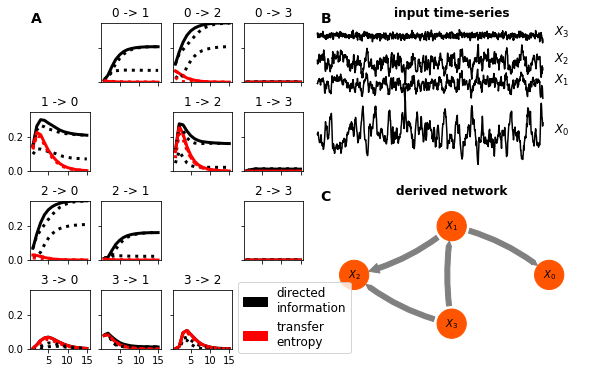

In [27]:
fig = plt.figure(figsize=(10, 6))
gs = plt.matplotlib.gridspec.GridSpec(4, 8, figure=fig, hspace=.5)
axes = np.array([[plt.subplot(gs[m, n]) for n in range(4)] for m in range(4)])
lw = 3
fs = 12
names = [r'$X_0$', r'$X_1$', r'$X_2$', r'$X_3$']
for pairs in itertools.combinations(range(4), 2):
    for ppairs in itertools.permutations(pairs):
        axes[ppairs].plot(lags, di[ppairs], 'k-', lw=lw)
        axes[ppairs].plot(lags, te[ppairs], 'r-', lw=lw)
        for ncond in range(2):
            axes[ppairs].plot(lags, cdi[ppairs + (ncond, )], 'k:', lw=lw)
            axes[ppairs].plot(lags, cte[ppairs + (ncond, )], 'r:', lw=lw)

        axes[pairs[0], pairs[1]].set_title(f'{pairs[0]} -> {pairs[1]}', fontsize=fs)
        axes[pairs[1], pairs[0]].set_title(f'{pairs[1]} -> {pairs[0]}', fontsize=fs)
    
for n in range(4): axes[n, n].axis('off')
for n, m in itertools.product(range(4), range(4)):
    if n != 3: axes[n, m].set_xticklabels([])
    if m != 0: axes[n, m].set_yticklabels([])
    axes[n, m].set_ylim(0, max(di.max(), te.max()))

rpatch = plt.matplotlib.patches.Patch(color='r')
kpatch = plt.matplotlib.patches.Patch(color='k')
fig.legend((kpatch, rpatch), ('directed\ninformation', 'transfer\nentropy'), loc=(.4, .07), fontsize=fs)
axes[0, 0].annotate('A', (0.02, 1), xycoords='axes fraction', fontsize=int(1.2*fs), fontweight='bold')


ax = plt.subplot(gs[2:, 4:])
ax.set_title('derived network', fontweight='bold')
pyemma.plots.plot_network(_n, pos=pos, state_labels=names, 
                          state_sizes=.1*np.ones(4), arrow_labels=None, ax=ax, figpadding=0.2, );
ax.annotate('C', (0.02, 1), xycoords='axes fraction', fontsize=int(1.2*fs), fontweight='bold')

ax = plt.subplot(gs[:2, 4:])
ax.axis('off')
stack = 0.
for n, ts in enumerate(tdat.T):
    ax.plot(ts[:1000] + 1.5*stack, 'k')
    ax.annotate(names[n], (1050, ts[:1000].mean() + 1.5*stack), annotation_clip=False, fontsize=fs)
    stack += ts[:1000].max()
ax.set_xlim(-10, 1200)
#ax.set_ylim(-10, stack*1.5)
ax.set_title('input time-series', fontweight='bold')
ax.annotate('B', (0.02, 1), xycoords='axes fraction', fontsize=int(1.2*fs), fontweight='bold')

#fig.savefig('/home/mi/thempel/Dokumente/Papers/directed-info-paper/article/img/ohrnstein_uhlenbeck.pdf')

In [ ]:
# black: DI; red: TE
# dotted lines: causally condited
# solid: normal